# Logistic Regression

The most common way to do Bayesian Logistic Regression is to use the Laplace Approximation.

## The Model

The model is the same as Linear Regression, except the output is passed through a Logistic Sigmoid to give output that is on [0,1].

$P(\mathbf{w}) = \mathcal{N}(\mathbf{0}, \alpha^{-1}\mathbf{I})$

$P(\mathbf{y} \mid \mathbf{X}, \mathbf{w} ) = \sigma(\mathcal{N}(\mathbf{Xw}, \beta^{-1}\mathbf{I}))$

## No More Conjugacy

This model is not conjugate - what we typically do is is approximate the posterior with a Normal distribution. This is a useful approximation, as we then have a conjugate posterior-likelihood pair. This means if we want a predictive distribution, everything is easy.

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.datasets import make_classification
%matplotlib inline

In [300]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(LogisticRegression, self).__init__()
        self.w = torch.nn.Linear(in_features, out_features, bias=True)
        
        self.bce = torch.nn.BCEWithLogitsLoss()
        
    def forward(self, x):
        return self.w(x)
    
    def loss(self, x, y):
        y_hat = self.forward(x)
        l2 = torch.matmul(self.w.weight, self.w.weight.transpose(0,1)).sum()+self.w.bias**2
        return self.bce(y_hat, y) + (1.0/3)*l2
        

In [301]:
lr = LogisticRegression(2,1)

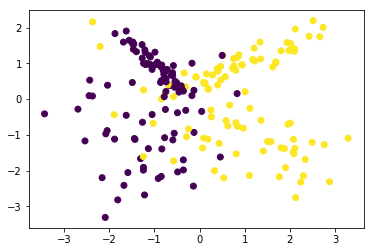

In [302]:
x, y = make_classification(n_samples=200, flip_y=0, n_features=2, n_informative=2, n_redundant=0, class_sep=1)
plt.scatter(x[:,0], x[:,1], c=y)

In [303]:
opt = torch.optim.Adam(lr.parameters(), lr=0.05)

In [304]:
x_t = torch.autograd.Variable(torch.from_numpy(x).float())
y_t = torch.autograd.Variable(torch.from_numpy(y.reshape(-1,1)).float())
for t in range(5000):
    opt.zero_grad()
    loss = lr.loss(x_t,y_t)
    loss.backward()
    opt.step()

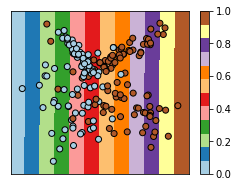

In [305]:
h=0.01
x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = lr.forward(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()).data.numpy()

# Put the result into a cololr plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.colorbar()
plt.show()